# Preparing and loading your data

In [1]:
from ase import Atoms
import schnetpack as spk
from schnetpack.interfaces.ase_interface import SpkEnsembleCalculator
import schnetpack.transform as trn
from schnetpack.datasets import MD17
import os
import numpy as np
from tqdm import tqdm
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
import matplotlib.pyplot as plt

## Predefined datasets

In [2]:
## Load the dataset
forcetut = './forcetut'
if not os.path.exists(forcetut):
    os.makedirs(forcetut)

ethanol_data = MD17(
    os.path.join(forcetut,'ethanol.db'),
    molecule='ethanol',
    batch_size=10,
    num_train=1000,
    num_val=1000,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        trn.RemoveOffsets(MD17.energy, remove_mean=True, remove_atomrefs=False),
        trn.CastTo32()
    ],
    num_workers=0,
    pin_memory=False, # set to false, when not using a GPU
)
ethanol_data.prepare_data()
ethanol_data.setup()

calculating statistics: 100%|██████████| 100/100 [00:00<00:00, 174.05it/s]


In [3]:
structure = ethanol_data.test_dataset[1]

# Define an ASE Atoms object
atoms = Atoms(numbers=structure[spk.properties.Z], positions=structure[spk.properties.R])

## Ensemble Interface to ASE

In [4]:
model_path_list = ['../../tests/testdata/md_ethanol.model',
                   '../../tests/testdata/md_ethanol_2.model']

In [64]:
abs_ensemble_calculator = SpkEnsembleCalculator(
    models=model_path_list,
    neighbor_list=trn.ASENeighborList(cutoff=5.0),
    energy_key=MD17.energy,
    force_key=MD17.forces,
    energy_unit="kcal/mol",
    position_unit="Ang",
    uncertainty_fn=SpkEnsembleCalculator.AbsoluteUncertainty
)

INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol.model
/Users/sundusaijaz/Desktop/TUProject/test/schnetpack/src/schnetpack/utils/compatibility.py:41: UserWarning: Model was saved without version information. Conversion to current version may fail.
  warnings.warn(
INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol_2.model


In [65]:
atoms.set_calculator(abs_ensemble_calculator)

/var/folders/d_/jqmy0d095dq5c1t9g8jxvjz40000gn/T/ipykernel_81868/1202942669.py:1: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(abs_ensemble_calculator)


In [15]:
print("Prediction:")
print("energy:", atoms.get_total_energy())
print("forces:", atoms.get_forces())

Prediction:
energy: -4212.3531728347
forces: [[ 0.39020337 -0.28103384  1.67950711]
 [ 3.48609868 -0.53285961 -1.44635642]
 [ 0.14382158  0.32812961 -0.19949942]
 [ 0.80402389 -0.33151784 -0.26060258]
 [-0.57253107 -0.38255051  0.08730937]
 [-0.2773256   0.04773329  0.46824267]
 [-3.40005778  0.74391005  0.45971792]
 [ 0.14574423  0.6275448   0.46960579]
 [-0.71997735 -0.21935587 -1.25792447]]


# Structure Optimization

In [78]:
input_structure_file = "../../tests/testdata/md_ethanol.xyz"

In [86]:
import random
from ase.io import read, write
# load initial structure
mol = read(input_structure_file)
pos = mol.get_positions()

# distort the structure
for n in range(pos.shape[0]):
    pos[n] = pos[n] * random.uniform(0.95,1.05)
    
molecule = Atoms(positions=pos, numbers=mol.get_atomic_numbers())


In [87]:
from ase.optimize.lbfgs import LBFGS
optimizer = LBFGS(molecule)

In [88]:
molecule.set_calculator(abs_ensemble_calculator)

/var/folders/d_/jqmy0d095dq5c1t9g8jxvjz40000gn/T/ipykernel_81868/2065683593.py:1: FutureWarning: Please use atoms.calc = calc
  molecule.set_calculator(abs_ensemble_calculator)


In [89]:
abs_uncertainties = []  

for _ in optimizer.irun(fmax=0.01, steps=100):
    abs_uncertainties.append(abs_ensemble_calculator.get_uncertainty(molecule))

       Step     Time          Energy          fmax
LBFGS:    0 23:22:15    -4211.327148        7.012325
LBFGS:    1 23:22:16    -4212.581013        2.397377
LBFGS:    2 23:22:16    -4212.686326        0.975172
LBFGS:    3 23:22:16    -4212.726735        0.678739
LBFGS:    4 23:22:16    -4212.767394        0.480538
LBFGS:    5 23:22:16    -4212.789566        0.370410
LBFGS:    6 23:22:16    -4212.799259        0.216350
LBFGS:    7 23:22:16    -4212.802698        0.166682
LBFGS:    8 23:22:16    -4212.804225        0.113353
LBFGS:    9 23:22:16    -4212.805012        0.076678
LBFGS:   10 23:22:16    -4212.805465        0.070476
LBFGS:   11 23:22:16    -4212.805769        0.062861
LBFGS:   12 23:22:16    -4212.805947        0.040551
LBFGS:   13 23:22:16    -4212.806043        0.029580
LBFGS:   14 23:22:16    -4212.806110        0.022964
LBFGS:   15 23:22:16    -4212.806162        0.020948
LBFGS:   16 23:22:16    -4212.806198        0.017136
LBFGS:   17 23:22:16    -4212.806229        0.01

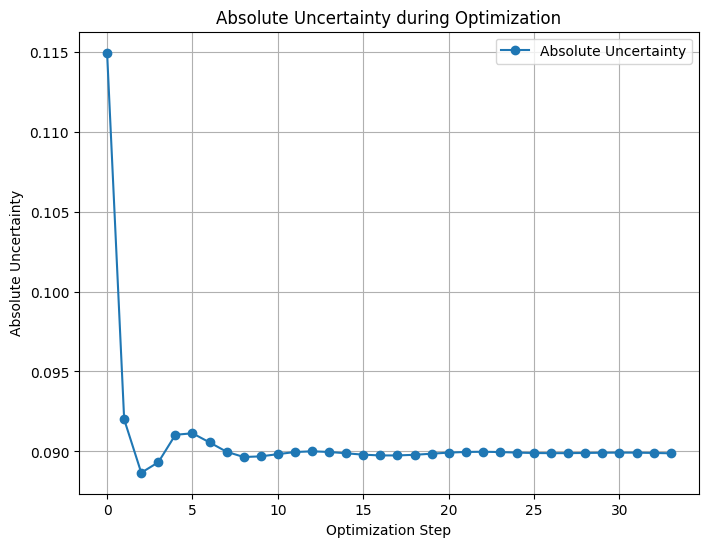

In [106]:
plt.figure(figsize=(8, 6))
plt.plot(abs_uncertainties, label="Absolute Uncertainty", marker='o')
plt.xlabel("Optimization Step")
plt.ylabel("Absolute Uncertainty")
plt.title("Absolute Uncertainty during Optimization")
plt.legend()
plt.grid(True)
plt.show()

## Relative Uncertainty

In [99]:
mol = read(input_structure_file)
pos = mol.get_positions()

# distort the structure
for n in range(pos.shape[0]):
    pos[n] = pos[n] * random.uniform(0.95,1.05)
    
molecule = Atoms(positions=pos, numbers=mol.get_atomic_numbers())


In [100]:

rel_ensemble_calculator = SpkEnsembleCalculator(
    models=model_path_list,
    neighbor_list=trn.ASENeighborList(cutoff=5.0),
    energy_key=MD17.energy,
    force_key=MD17.forces,
    energy_unit="kcal/mol",
    position_unit="Angstrom",
    uncertainty_fn=SpkEnsembleCalculator.RelativeUncertainty 
)

INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol.model
INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol_2.model


In [101]:
optimizer = LBFGS(molecule)

In [102]:
molecule.set_calculator(rel_ensemble_calculator)

/var/folders/d_/jqmy0d095dq5c1t9g8jxvjz40000gn/T/ipykernel_81868/3665720284.py:1: FutureWarning: Please use atoms.calc = calc
  molecule.set_calculator(rel_ensemble_calculator)


In [103]:
rel_uncertainties = []  

for _ in optimizer.irun(fmax=0.01, steps=100):
    rel_uncertainties.append(rel_ensemble_calculator.get_uncertainty(molecule))

       Step     Time          Energy          fmax
LBFGS:    0 23:24:00    -4211.591234        8.626141
LBFGS:    1 23:24:00    -4212.449263        2.588802
LBFGS:    2 23:24:00    -4212.680193        1.623366
LBFGS:    3 23:24:00    -4212.735744        0.702930
LBFGS:    4 23:24:00    -4212.775188        0.539084
LBFGS:    5 23:24:00    -4212.793622        0.448405
LBFGS:    6 23:24:00    -4212.799869        0.184303
LBFGS:    7 23:24:00    -4212.802148        0.128915
LBFGS:    8 23:24:00    -4212.804013        0.130364
LBFGS:    9 23:24:01    -4212.805084        0.105009
LBFGS:   10 23:24:01    -4212.805523        0.063450
LBFGS:   11 23:24:01    -4212.805740        0.044986
LBFGS:   12 23:24:01    -4212.805952        0.048575
LBFGS:   13 23:24:01    -4212.806121        0.044823
LBFGS:   14 23:24:01    -4212.806243        0.039989
LBFGS:   15 23:24:01    -4212.806347        0.037455
LBFGS:   16 23:24:01    -4212.806448        0.044372
LBFGS:   17 23:24:01    -4212.806516        0.02

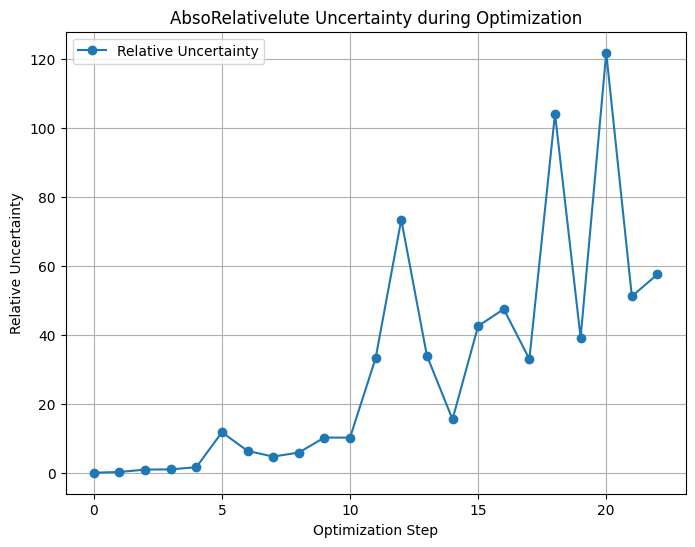

In [112]:

plt.figure(figsize=(8, 6))
plt.plot(rel_uncertainties, label="Relative Uncertainty", marker='o')
plt.xlabel("Optimization Step")
plt.ylabel("Relative Uncertainty")
plt.title("AbsoRelativelute Uncertainty during Optimization")
plt.legend()
plt.grid(True)
plt.show()



# Molecular Dynamics

In [109]:

T = 500
sampling_interval = 10
n_steps = 1000
step_size = 0.5

MaxwellBoltzmannDistribution(molecule, temperature_K=T)

dyn = Langevin(
    molecule, 
    timestep=step_size * units.fs, 
    temperature_K=T,
    friction=0.001 / units.fs
)

ats_traj = []
uncertainties = []
e_kin = []
e_pot = []
e_tmp = []


for i in tqdm(range(n_steps // sampling_interval)):
    dyn.run(sampling_interval)
    
    e_pot.append(molecule.get_potential_energy())
    e_kin.append(molecule.get_kinetic_energy())
    e_tmp.append(molecule.get_temperature())
    uncertainties.append(abs_ensemble_calculator.get_uncertainty(molecule))
    
    ats_traj.append(mol.copy())

100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


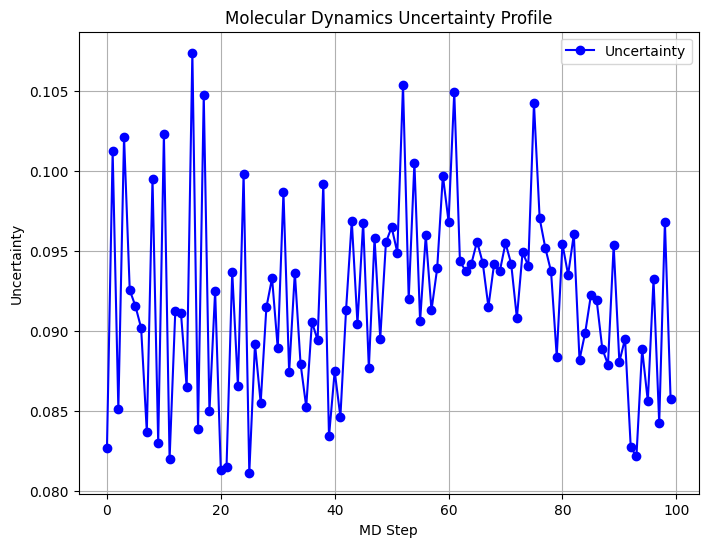

In [110]:
plt.figure(figsize=(8,6))
plt.plot(uncertainties, marker='o', color='blue', label='Uncertainty')
plt.xlabel("MD Step")
plt.ylabel("Uncertainty")
plt.title("Molecular Dynamics Uncertainty Profile")
plt.grid(True)
plt.legend()
plt.show()

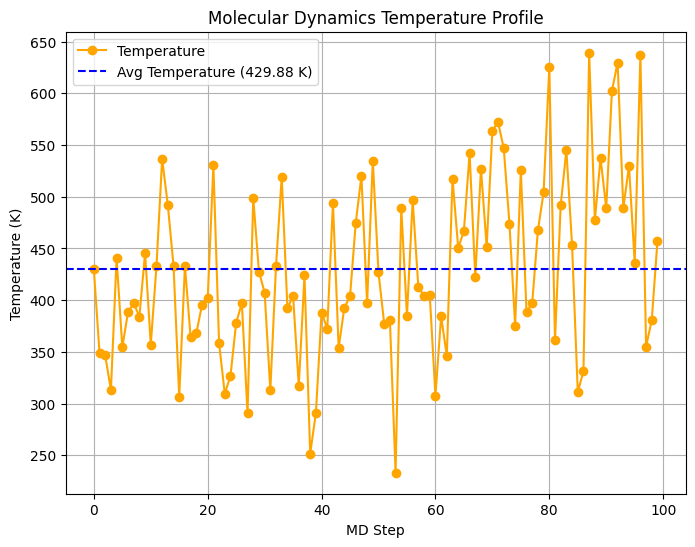

In [111]:
avg_temperature = np.mean(e_tmp)

plt.figure(figsize=(8,6))
plt.plot(e_tmp, marker='o', color='orange', label='Temperature')
plt.axhline(y=avg_temperature, color='blue', linestyle='--', label=f'Avg Temperature ({avg_temperature:.2f} K)')
plt.xlabel("MD Step")
plt.ylabel("Temperature (K)")
plt.title("Molecular Dynamics Temperature Profile")
plt.grid(True)
plt.legend()
plt.show()